<div>
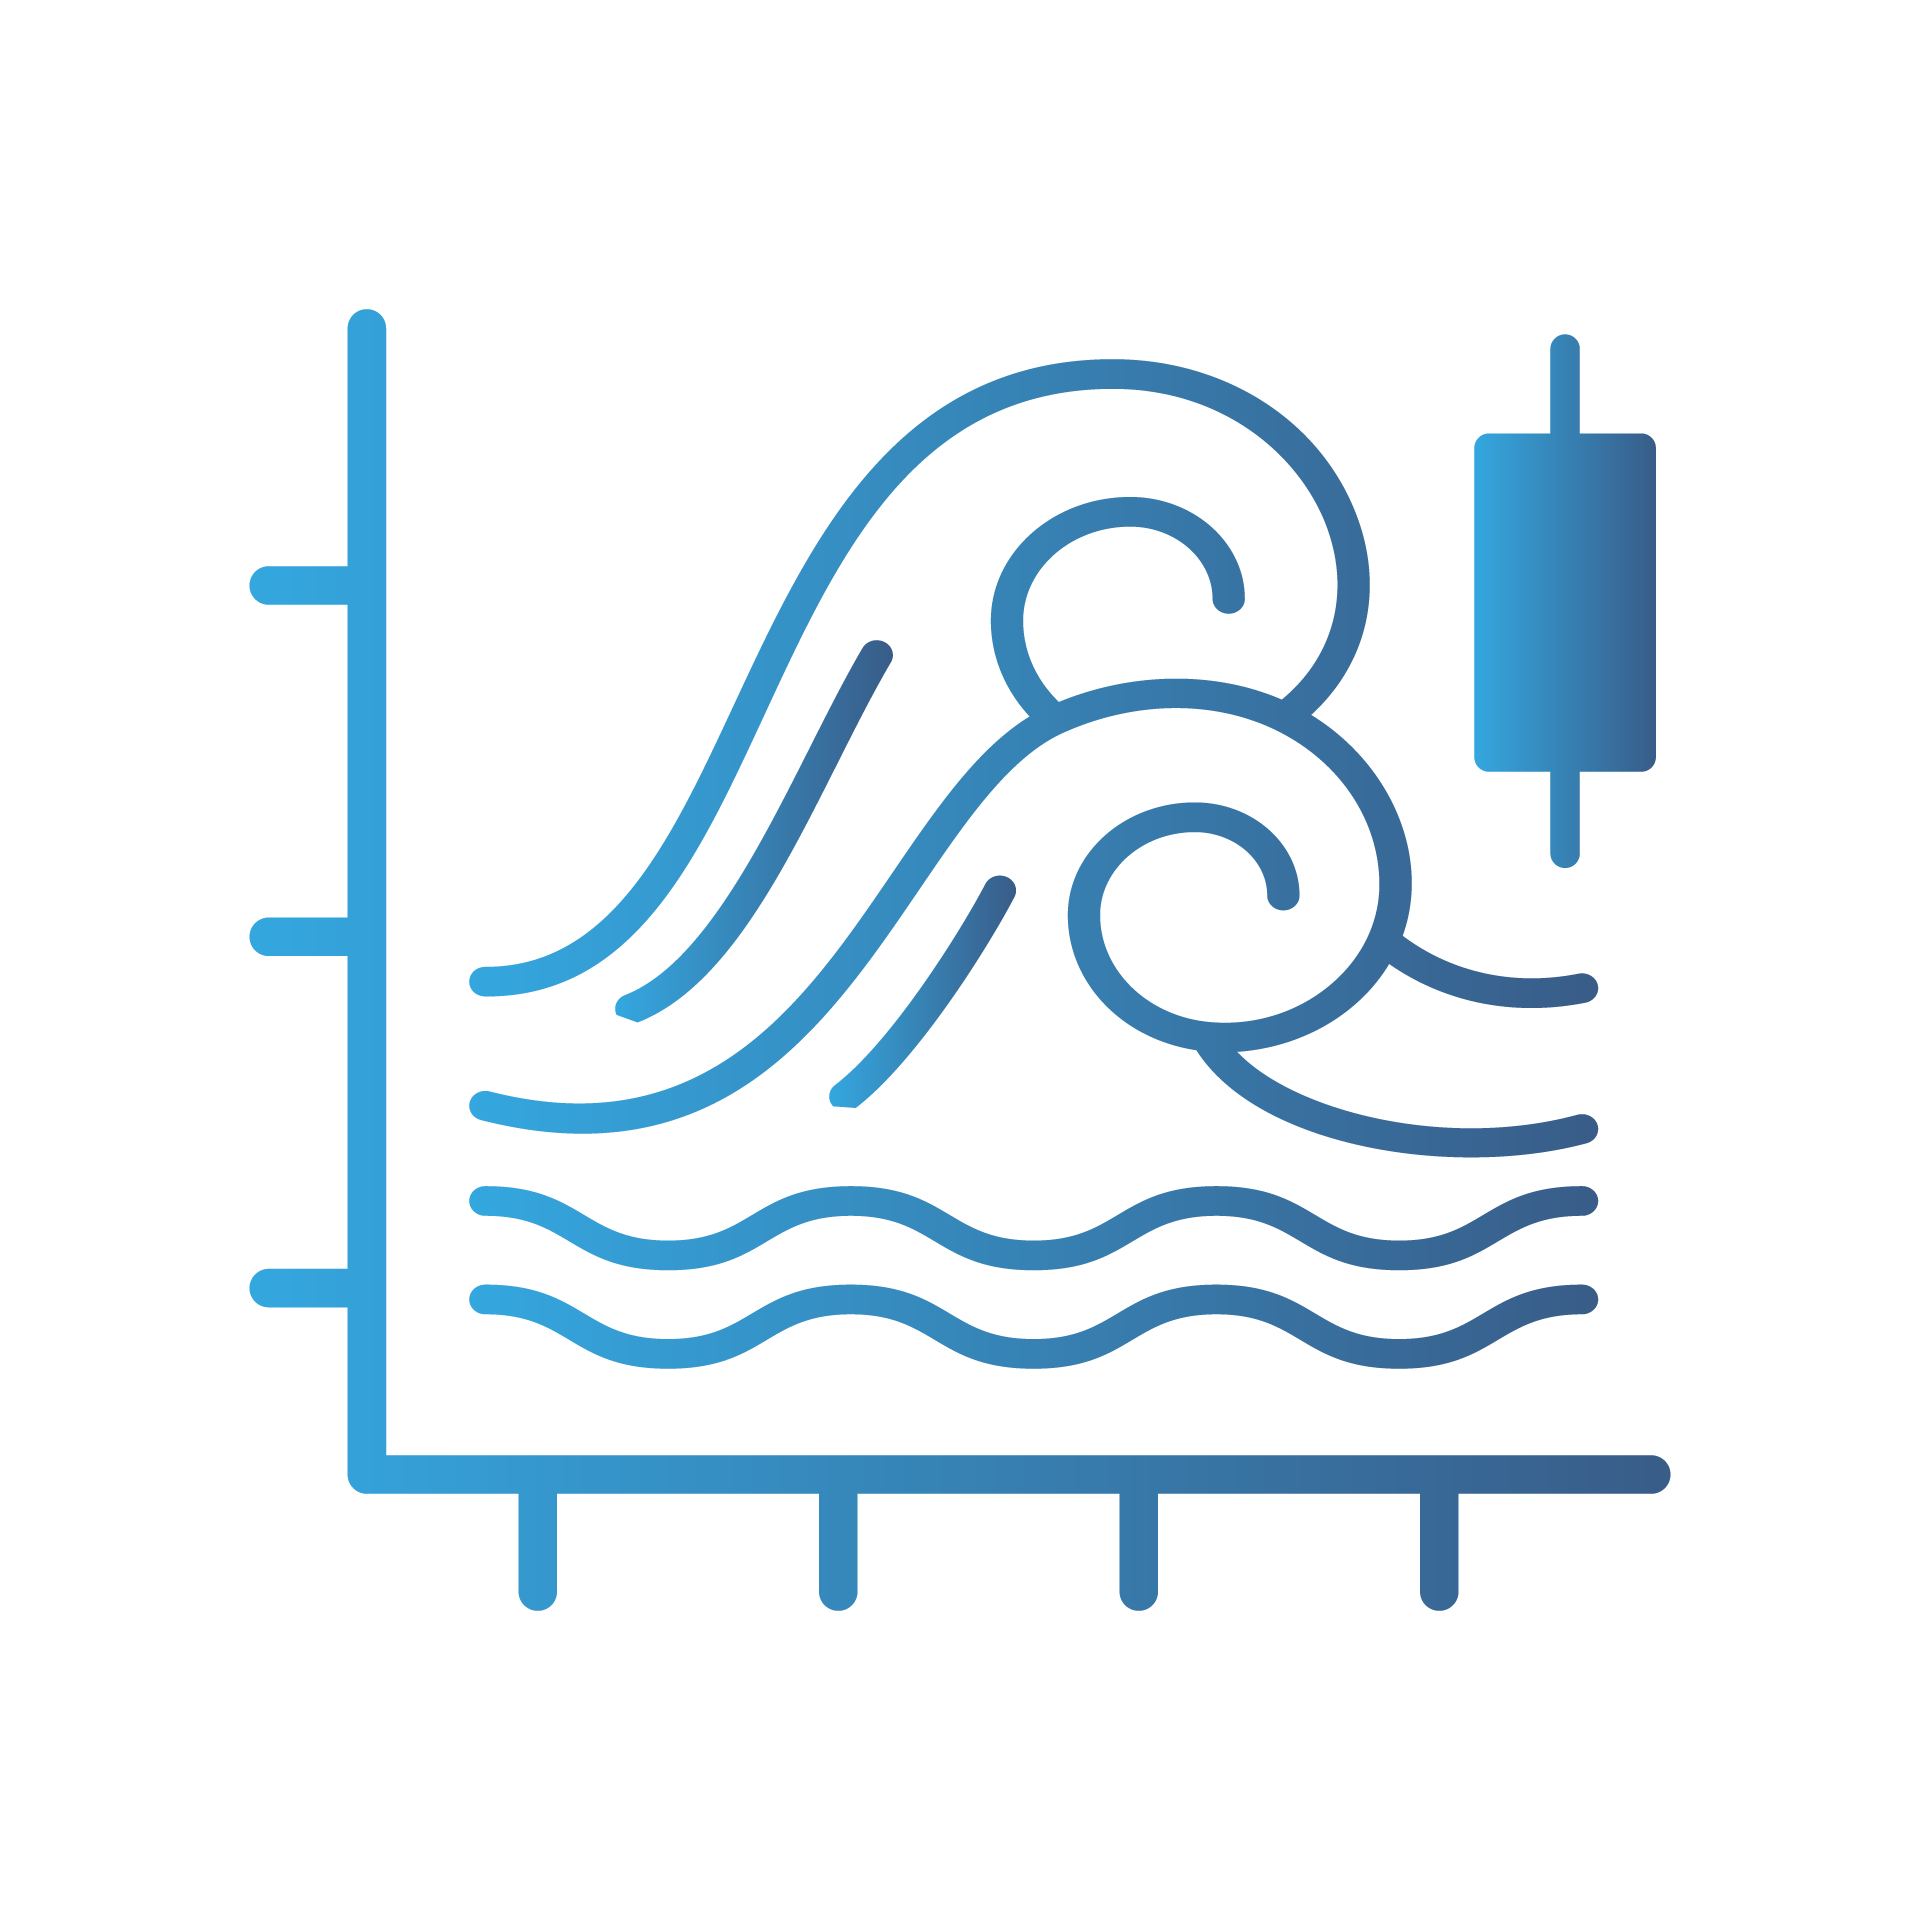
</div>

# __Ocean Regimes Indicator__: Model development notebook

*Authors*: Andrea Garcia Juan (andrea.garcia.juan@ifremer.fr), Kevin Balem (kevin.balem@ifremer.fr), Guillaume Maze (gmaze@ifremer.fr), and Loïc Bachelot (loic.bachelot@ifremer.fr)
***

## Description

**The objective of this notebook is to create a model, optimize the model parameters, and save it for later use.**

The __Gaussian Mixture Models__ (GMM) allow to automatically assemble time series of ocean variables in clusters according to their seasonal variability. Depending on the dataset, such clusters can show space coherence. This coherence is what we call the __Ocean Regimes Indicator__. This example is based on the work of Fabrizio D'Ortenzio ([*D'Ortenzio and d'Alcalà, Biogeosciences, 2009*](https://bg.copernicus.org/articles/6/139/2009/)) and Nicolas Mayot ([*Mayot et al, Biogeosciences, 2016*](https://bg.copernicus.org/articles/13/1901/2016/)). For more information about the GMM model, see [*Maze et al, Prg.Oc, 2017*](https://www.sciencedirect.com/science/article/pii/S0079661116300714).

As an example, a subset of chlorophyll data from the ``OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082`` CMEMS product covering the Mediterranean is available as a training dataset.

The optimized model you are going to create can be saved and later applied to another dataset using the ``PreditandPlot_OceanRegimes.ipynb`` notebook, where you can plot and analyze the results.

***
This notebook has been developed at Laboratory for Ocean Physics and Satellite remote sensing, IFREMER, within the framework of the Blue-Cloud project. Blue-Cloud has received funding from the European Union's Horizon programme call BG-07-2019-2020, topic: [A] 2019 - Blue Cloud services, Grant Agreement n.862409


<div>
<center>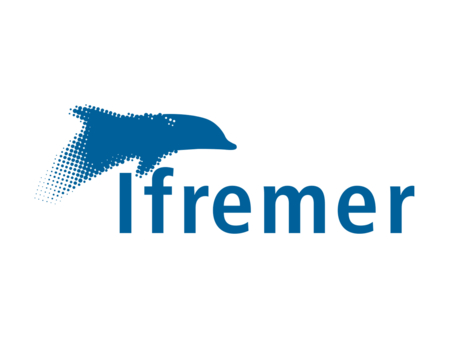 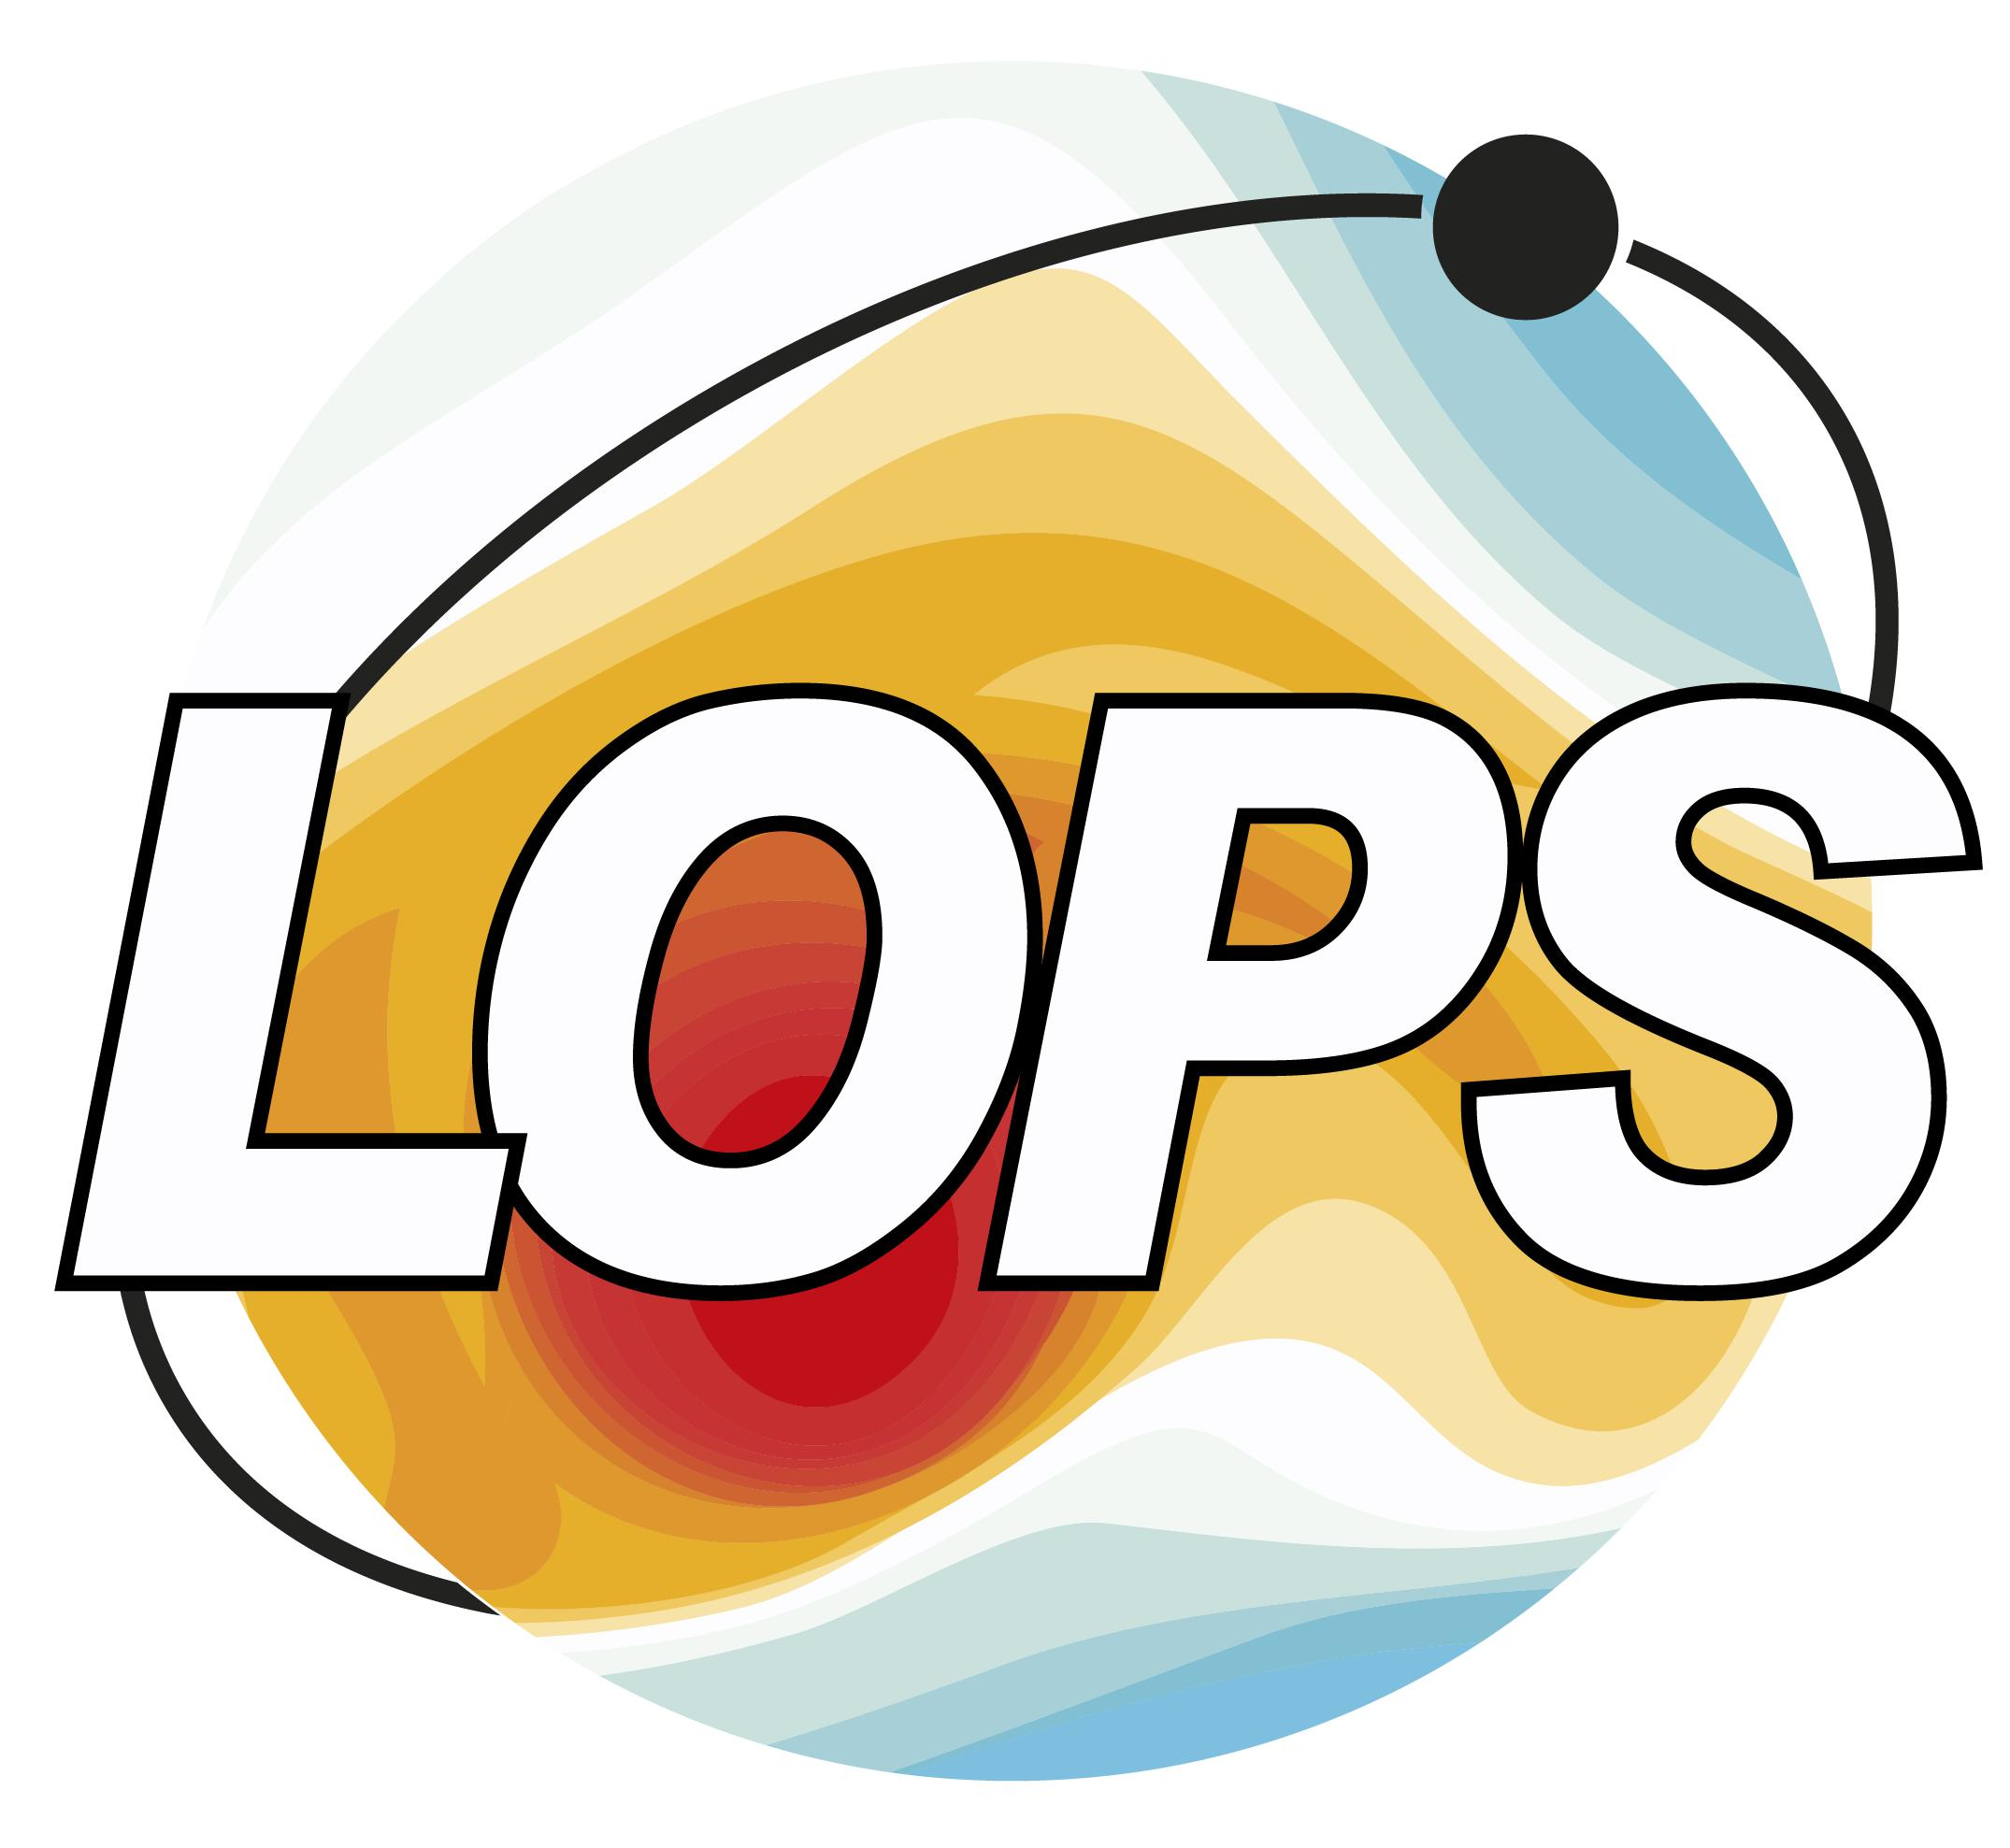 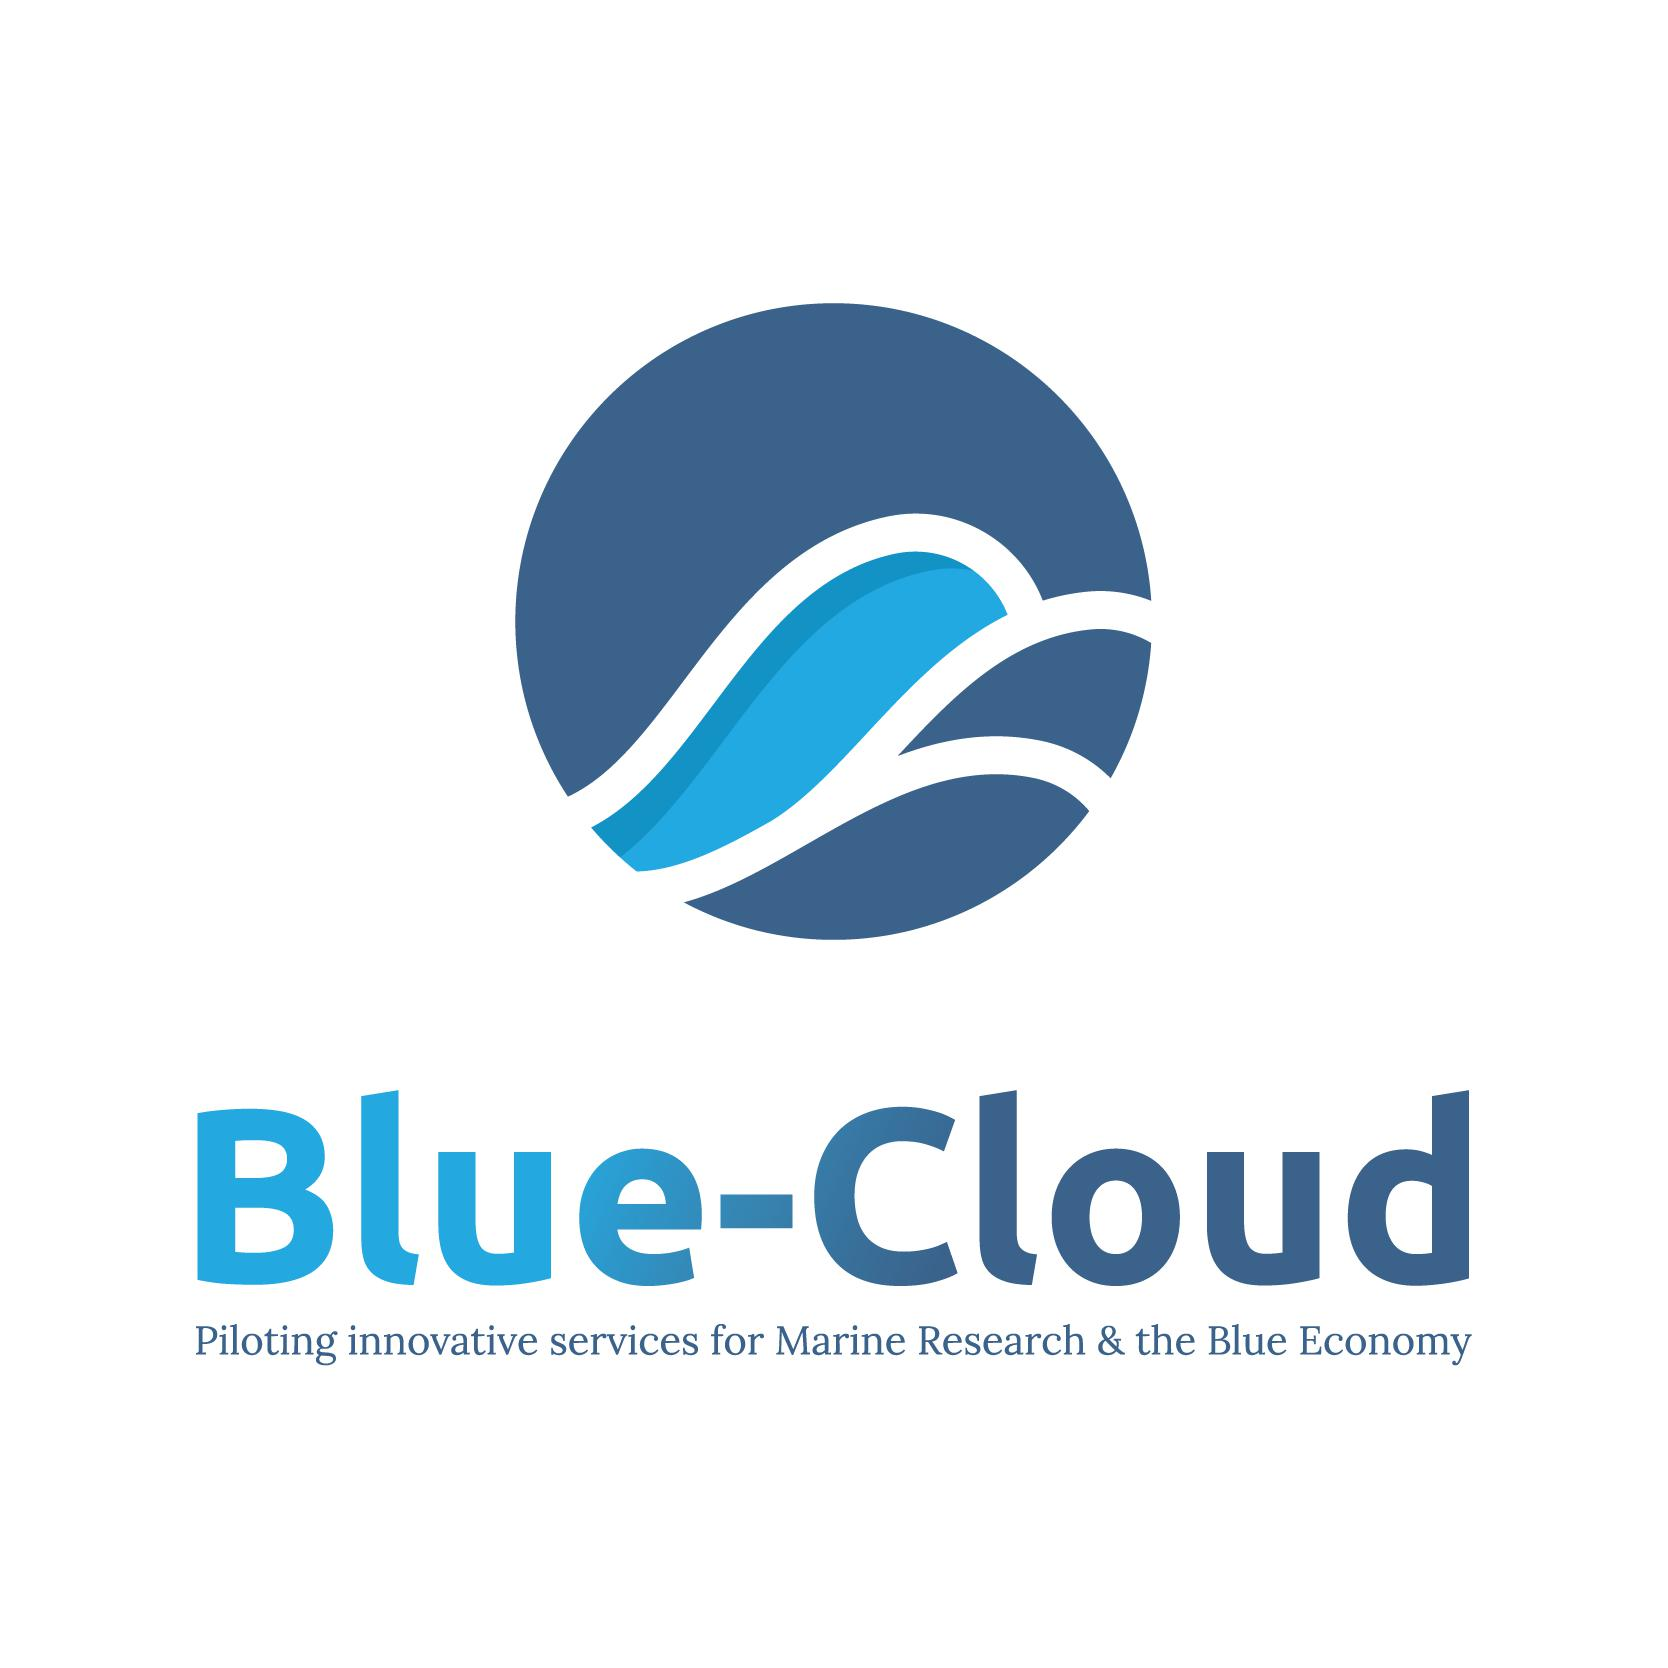</center>
</div>

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import mixture

from preprocessing_OR import *

from BIC_calculation_OR import *

import Plotter_OR
from Plotter_OR import Plotter_OR 

import subprocess

import joblib

## Model parameters
***

In this section, you must choose the __number of classes__ (*K*) you want to use to design your model.

You can choose a low number at the beginning (around 6 is a good general start). 
In the plot section, you will optimize the number of classes using the BIC plot. 
Then you will use the optimized number of classes to train the model again.

In [2]:
K=7

## Load training dataset
***

__Choose training dataset__

The training dataset is downloaded from CMEMS servers, so you will need to have a __CMEMS account__ (you can sign up [here](https://resources.marine.copernicus.eu/?option=com_csw&task=results?option=com_csw&view=account)).

You should provide your CMEMS __user name__ and __password__ below.

In [3]:
CMEMS_user = '########'
CMEMS_password = '########'

Data comes from daily Chlorophyll-a fields of *OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082* product, based on a space-time interpolation and a multi-sensors approach and with a spatial resolution of 4km (click [here](https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082) for getting all the information about the dataset). As an example, we propose to you a selection covering the Mediterranean sea during 2019.

If you feel confident you can modify downloading parameters (cell below) to test other dataset selections than the one we propose here (covering the Mediterranean). You can also test other variables. Please, be careful with memory limits: do not choose very big geographical extents or very long time series.

In [4]:
# geographical extent
geo_extent = [-5, 42, 30, 46] # [min lon, max lon, min lat, max lat]
# time extent
time_extent = ["2019-06-01", "2019-12-31"] # ["min date", "max date"]
# variable to be predict
var_name = 'CHL' # name in dataset
# file name
file_name = 'oceancolour_glo_chl_l4_rep_observations_009_082_mid2019_2.nc'

__Load training dataset__

Training dataset is download from __CMEMS__ servers using a Motu client and saved as a NetCDF file in *datasets/* folder in your workspace. Downloading will take some minutes.

In [5]:
bashCommand = 'python -m motuclient -u ' + CMEMS_user + ' -p ' + CMEMS_password + ' -m "http://my.cmems-du.eu/motu-web/Motu" \
-s OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082-TDS -d dataset-oc-glo-bio-multi-l4-chl_interpolated_4km_daily-rep \
-x ' + str(geo_extent[0]) + ' -X ' + str(geo_extent[1]) + ' -y ' + str(geo_extent[2]) + ' -Y ' + str(geo_extent[3]) + \
' -t "' + time_extent[0] + '" -T "' + time_extent[1] + '" -z 0.0 -Z 2500.0 \
-v ' + var_name + ' -o datasets -f ' + file_name
print(bashCommand)
sp = subprocess.call(bashCommand, shell=True)

python -m motuclient -u agarcia6 -p 1802910672Aa# -m "http://my.cmems-du.eu/motu-web/Motu" -s OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082-TDS -d dataset-oc-glo-bio-multi-l4-chl_interpolated_4km_daily-rep -x -5 -X 42 -y 30 -Y 46 -t "2019-06-01" -T "2019-12-31" -z 0.0 -Z 2500.0 -v CHL -o datasets -f oceancolour_glo_chl_l4_rep_observations_009_082_mid2019_2.nc


The training dataset is loaded from the NetCDF file as an *xarray* dataset:

In [6]:
file_path = 'datasets/' + file_name
ds = xr.open_dataset(file_path)

# some format
ds['time'] = ds.indexes['time'].to_datetimeindex()
ds.time.attrs['axis'] = 'T'

print(ds)

<xarray.Dataset>
Dimensions:  (lat: 385, lon: 1128, time: 214)
Coordinates:
  * time     (time) datetime64[ns] 2019-06-01 2019-06-02 ... 2019-12-31
  * lat      (lat) float32 46.02 45.98 45.94 45.9 ... 30.15 30.1 30.06 30.02
  * lon      (lon) float32 -4.979 -4.937 -4.896 -4.854 ... 41.9 41.94 41.98
Data variables:
    CHL      (time, lat, lon) float32 ...
Attributes: (12/65)
    comment:                      average
    distribution_statement:       See CMEMS Data License
    site_name:                    GLO
    parameter_code:               CHL
    creation_time:                16:39:54 UTC
    creation_date:                2020-11-05 UTC
    ...                           ...
    parameter:                    Chlorophyll-a concentration
    History:                      Translated to CF-1.0 Conventions by Netcdf-...
    geospatial_lat_min:           30.020832061767578
    geospatial_lat_max:           46.02083206176758
    geospatial_lon_min:           -4.979161262512207
    geospat

Quick plot of the training dataset. Please, choose a time slice if needed.

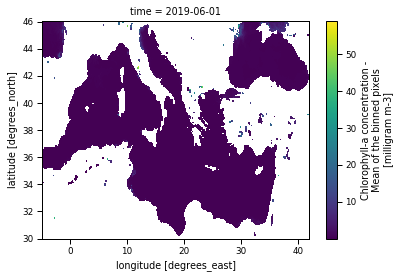

In [7]:
ds[var_name].isel(time=0).plot();

You can also plot the dataset __histogram__ and a __box plot__ to have an idea of Chlorophyll-a values distribution. Here we use a logarithmic scale because of the amount of outliers in the example dataset. If you don't need a logarithmic scale for your dataset, feel free to modify the cell below.

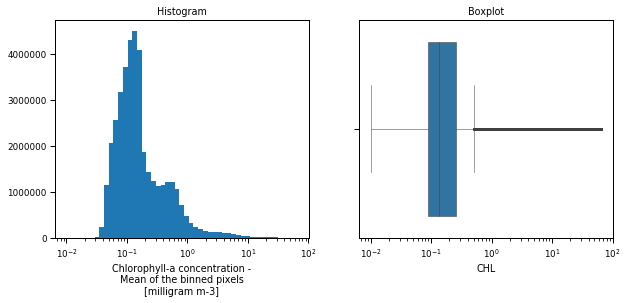

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
# histogram
bins = np.logspace(np.log10(ds[var_name].min().values),np.log10(ds[var_name].max().values), 50) # log bins
ds[var_name].plot.hist(bins=bins, ax=ax[0], xscale="log");
# boxplot
g2 = sns.boxplot(x=ds[var_name], fliersize=1, linewidth=0.5, ax=ax[1])
g2.set_xscale("log")
g2.set_title("Boxplot");

## Preprocessing
***

Before using the training dataset, you need to format it. The preprocessing phase consists of 5 different steps that are explained below.

__1. Weekly mean__

For each time series (each pixel) a weekly mean is applied. It allows us to __smooth the time series__, focusing on the seasonal variability. The dimensions on the dataset are also reduced, so processing time will be shortened. If your dataset contains more than one year, all years are taken together in the weakly mean, creating weekly climatological time series. This “*week*” dimension will be called “*feature*” in the preprocessed dataset.

In [9]:
X = OR_weekly_mean(ds, var_name=var_name)

__2. Reduce latitude and longitude to sampling dimension__

The dataset is stacked into a __2D dataset__ with dimensions "*feature*" (corresponding to weeks) and "*sampling*" (corresponding to latitude and longitude). Latitude and longitude information is not taken into account by the model: it only sees a set of "independent" time series and uses the similarities in temporal variability to make the clusters. 

In [10]:
X = OR_reduce_dims(X)

__3. Delate all NaN values__

NaNs values are removed using a __mask__. Here we use our own Mediterranean mask for removing the Black Sea, the Atlantic Ocean, and the lakes. If you are using a different dataset, you can use your own mask (look at the *docstring* of the function to know mask requirements) or you can automatically produce your mask from the dataset (default option ``mask_path='auto'``). The mask will be used below for unstacking the final dataset.

In [11]:
X, mask = OR_delate_NaNs(X, var_name =var_name, mask_path='datasets/Mediterranean_mask.nc')

Quick plot of the mask.

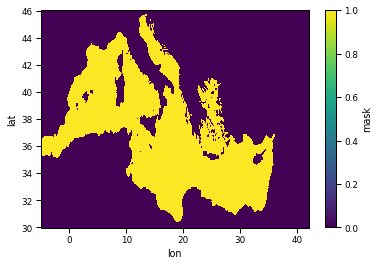

In [12]:
mask['mask'].plot()

__4. Scaler__

The sklearn __StandardScaler__ is applied: it standardizes the *feature* dimension by removing the mean and scaling to unit variance. For more information, see [sklearn doc](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

Depending on your dataset you may prefer to use other scalers. You can choose other options using the ``scaler_name`` input: [Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html) and [MinMax Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).  

In [13]:
X = OR_scaler(X, var_name=var_name)

__5. Principal Component Analysis (PCA)__

A PCA (Principal Component Analysis) is applied. The PCA __reduces the feature dimensions__ by projecting the data into a lower-dimensional space. With the ``n_components`` option, you can choose the amount of variance that needs to be explained by the reduced components (default value is 0.99).

In [14]:
X = OR_apply_PCA(X, var_name=var_name)

The preprocessed dataset contains a new "__*CHL_reduced*__" variable with dimensions "*feature_reduced*" and "*sampling*" that will be used for training the model.

In [15]:
print(X)

<xarray.Dataset>
Dimensions:      (feature: 32, feature_reduced: 23, sampling: 140699)
Coordinates:
  * feature      (feature) int64 1 22 23 24 25 26 27 28 ... 46 47 48 49 50 51 52
  * sampling     (sampling) MultiIndex
  - lat          (sampling) float64 45.73 45.73 45.73 ... 30.35 30.35 30.35
  - lon          (sampling) float64 13.56 13.6 13.65 13.19 ... 19.23 19.27 19.31
Dimensions without coordinates: feature_reduced
Data variables:
    CHL          (sampling, feature) float32 13.09 3.965 6.854 ... 0.2549 0.2506
    CHL_scaled   (sampling, feature) float32 43.95 10.4 12.94 ... -0.1358 -0.229
    CHL_reduced  (sampling, feature_reduced) float32 59.97 -31.63 ... 0.09274


## Create and train a model
***

In this section, you can create your own model using the number of classes *K*. Then, the model is trained (__fitted__) to the training dataset and the time series are classified (__predict__) in order to make some useful plots in the next section.

### Create model

We use a GMM (__Gaussian Mixture Models__) which decomposes the PDF (Probability Density Function) of the dataset into a sum of gaussians. For more information, see [*Maze et al, Prg.Oc, 2017*](https://www.sciencedirect.com/science/article/pii/S0079661116300714).

In [16]:
model = mixture.GaussianMixture(n_components=K, covariance_type='full')
model

GaussianMixture(n_components=7)

### Fit model

In [17]:
X_labels = model.fit_predict(X[var_name + "_reduced"])
X = X.assign(variables={"GMM_labels":(('sampling'),X_labels)})

__Robustness__

The classification robustness is a scaled version of the __probability__ of a time series to belong to a class. 
A 0 value indicates the model is totally unsure of the classification result (all classes are equiprobable), while values close to 1 indicate the model is highly confident of the result. 

Robustness will be used in the Development plots section to optimize the model parameters.

In [18]:
# calculate probability
X_proba = model.predict_proba(X[var_name + "_reduced"])
X = X.assign(variables={"GMM_post":(('sampling','k'),X_proba)})

# calculate robustness
maxpost = X["GMM_post"].max(dim="k")
nK = len(X["GMM_labels"])
robust = (maxpost - 1. / nK) * nK / (nK - 1.)
Plist = [0, 0.33, 0.66, 0.9, .99, 1]
rowl0 = ('Unlikely', 'As likely as not', 'Likely', 'Very Likely', 'Virtually certain')
robust_id = np.digitize(robust, Plist) - 1

X = X.assign(variables={"GMM_robustness":(('sampling'), robust), "GMM_robustness_cat":(('sampling'), robust_id)})
X["GMM_robustness_cat"].attrs['legend'] = rowl0

print(X)

<xarray.Dataset>
Dimensions:             (feature: 32, feature_reduced: 23, k: 7, sampling: 140699)
Coordinates:
  * feature             (feature) int64 1 22 23 24 25 26 ... 47 48 49 50 51 52
  * sampling            (sampling) MultiIndex
  - lat                 (sampling) float64 45.73 45.73 45.73 ... 30.35 30.35
  - lon                 (sampling) float64 13.56 13.6 13.65 ... 19.27 19.31
Dimensions without coordinates: feature_reduced, k
Data variables:
    CHL                 (sampling, feature) float32 13.09 3.965 ... 0.2506
    CHL_scaled          (sampling, feature) float32 43.95 10.4 ... -0.229
    CHL_reduced         (sampling, feature_reduced) float32 59.97 ... 0.09274
    GMM_labels          (sampling) int64 1 1 1 1 1 1 1 1 1 ... 6 6 6 6 6 6 6 6 6
    GMM_post            (sampling, k) float64 0.0 1.0 0.0 ... 5.836e-13 0.9996
    GMM_robustness      (sampling) float64 1.0 1.0 1.0 ... 0.9185 0.9921 0.9996
    GMM_robustness_cat  (sampling) int64 5 5 5 5 5 5 5 5 5 ... 3 4 4 3 2 2 

Finally, the dataset including the results is __unstacked__.

In [19]:
ds_labels = OR_unstack_dataset(ds, X, mask)
print(ds_labels)

<xarray.Dataset>
Dimensions:             (feature: 32, feature_reduced: 23, k: 7, lat: 385, lon: 1128, time: 214)
Coordinates:
  * lat                 (lat) float64 30.02 30.06 30.1 ... 45.94 45.98 46.02
  * lon                 (lon) float64 -4.979 -4.937 -4.896 ... 41.9 41.94 41.98
  * feature             (feature) int64 1 22 23 24 25 26 ... 47 48 49 50 51 52
  * time                (time) datetime64[ns] 2019-06-01 ... 2019-12-31
Dimensions without coordinates: feature_reduced, k
Data variables:
    CHL                 (feature, lat, lon) float32 nan nan nan ... nan nan nan
    CHL_scaled          (feature, lat, lon) float32 nan nan nan ... nan nan nan
    CHL_reduced         (feature_reduced, lat, lon) float32 nan nan ... nan nan
    GMM_labels          (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    GMM_post            (k, lat, lon) float64 nan nan nan nan ... nan nan nan
    GMM_robustness      (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    GMM_robustness_cat

## Development plots
***

The plots in this section will help you to __optimize__ the model parameters (especially the number of classes) and to take a look at how the classification behaves. Some of the functions contained in the Plotter_OR class will be used in this section.

In [20]:
P = Plotter_OR(ds_labels, model)

#### __1. Scatter plot__

The histograms of the __first 2 components of the reduced variable__ are plotted in the diagonal subplots and a scatter plot is shown in the upright subplot. Data is colored depending on the different classes. The 2 first components of the reduced variable contain most of the information in the dataset. So, this plot will help you to understand your dataset distribution and how the model is constructing the clusters. As we are using a GMM, the model separates the dataset PDF (Probability Density Function) into a sum of gaussians to define each cluster. 

In [ ]:
P.scatter_PDF(var_name = var_name + '_reduced')
P.save_BlueCloud('figures/scatter_PDF_EX_chl.png')

#### __2. BIC__

The BIC ([Bayesian Information Criteria](https://en.wikipedia.org/wiki/Bayesian_information_criterion)) can be used to __optimize the number of classes__ in the model, trying not to over-fit or under-fit the data. To compute this index, the model is fitted to the training dataset for a range of K values from 0 to 20. A __minimum__ in the BIC curve will give you the optimal number of classes to be used.

Moreover, for each K range run, a subset of the training dataset is randomly selected in order to use *independent* time series. Indeed, the ocean exhibits spatial correlations that reduce the real information contained in the training dataset. This has to be taken into account. This turns to our advantage here because the grid of the dataset allows us to draw several subsets of uncorrelated time series, finally allowing us to compute several times each K range run and hence to compute a standard deviation on the BIC metric.

The spatial correlation scale to consider is determined by the user. 
Values in the cell below are ok for the Mediterranean sea example shown here.
If you want to try another geographical selection or another variable you may change these numbers.

You can also choose the number of runs and the maximum number of classes, taking into account that increasing these numbers will increase the computation time. 

__User input__

In [ ]:
corr_dist = 40 # correlation distance in km
Nrun = 10 # number of runs for each k
NK = 20 # max number of classes to explore

__BIC calculation__

Calculation can take a few minutes.

In [ ]:
BIC, BIC_min = BIC_calculation(X=X, coords_dict={'latitude':'lat', 'longitude':'lon'}, 
                               corr_dist=corr_dist,
                               feature_name='feature_reduced', var_name= 'CHL_reduced',
                               Nrun=Nrun, NK=NK)

__BIC plot__

In [ ]:
plot_BIC(BIC, NK=NK)
P.save_BlueCloud('figures/BIC_EX_chl.png', bic_fig='yes')

__Optimized number of classes__

In [ ]:
BIC_min

If this is not the number of classes you chose in the beginning of the notebook, don't worry, you will fit your model again with the appropriate number of classes at the end of the notebook.

The BIC curve may not show a clear minimum. This can be an indication that some time series remained correlated in the training set, so try to adjust more precisely the correlation scale.

If the BIC curve has a clear minimum, don't forget to take into account the standard deviation. The BIC curve indicates a statistical optimum, so if the minimum is not above the standard deviation range, then it is indicative of an optimal **range** rather than a precise value. In this case, use your expertise to choose the number of classes (within the BIC allowed range) leading to ocean regimes that simply make the most sense to you.

#### __3. Robustness__

The model robustness represents a useful scaled __probability__ of a time series to belong to a class. If a lot of time series show very low values you should maybe change the number of classes.

Figure saved in figures/robustness_EX_chl.png


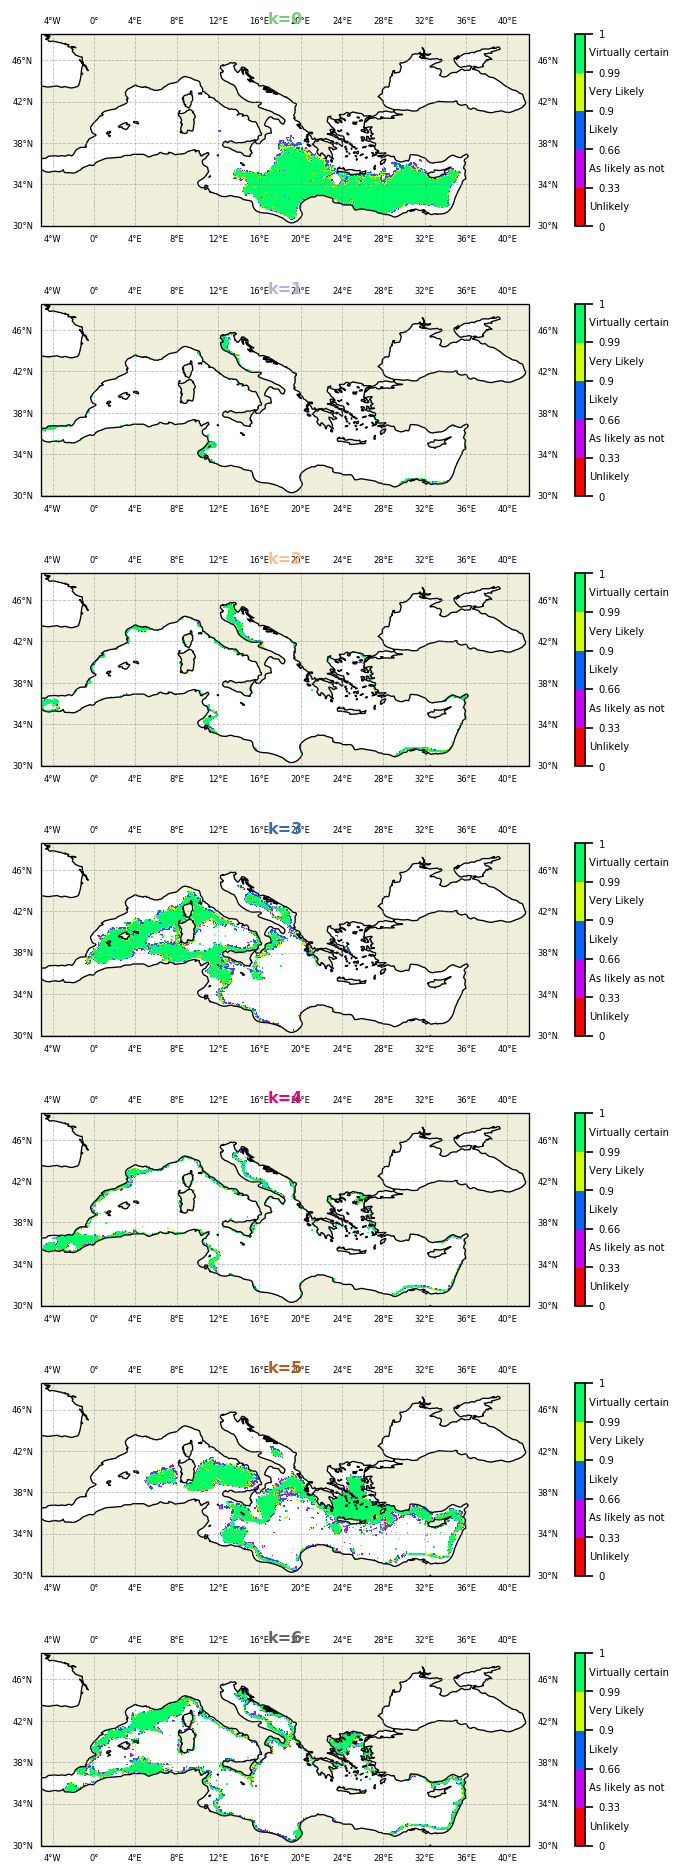

In [21]:
P.plot_robustness()
P.save_BlueCloud('figures/robustness_EX_chl.png')

## Refit and save model
***

As you now know which is the __best number of classes__ to classify your dataset profiles, you can train (fit) the model again with the appropriate number of classes.

In [ ]:
# appropriate number of classes
#K = BIC_min
K = 7

model = mixture.GaussianMixture(n_components=K, covariance_type='full')
model = model.fit(X[var_name + "_reduced"])

If you are satisfied with your model, you can save it in the *models/* folder and use it with the ``PredictandPlot_OceanRegimes.ipynb`` notebook to classify (predict) a dataset and plot the results corresponding to __Ocean  Regimes Indicator__.

In [22]:
joblib.dump(model, 'models/test_modelOR_mediterranean_chl_2019_k7_mid2.sav')

['models/test_modelOR_mediterranean_chl_2019_k7_mid2.sav']